In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

# Absolute Trading Costs are 1 basis point
ABS_TCOSTS = 0.0005
# Relative Trading Costs are 10 basis points
REL_TCOSTS = 0.0010


In [2]:
def generate_index(X): 
    rweights = np.random.uniform(0,1,X.shape[1])
    rweights = rweights/np.sum(rweights)
    portfolio = np.dot(X,rweights)

    return portfolio, rweights 

In [3]:
import statsmodels.api as sm

def ols_regression(X, y):
    # Add a constant column to the X matrix
    X = sm.add_constant(X)

    # Fit the OLS model
    model = sm.OLS(y, X)
    results = model.fit()

    # Return the fitted values
    return results


In [4]:
from sklearn.linear_model import Ridge

def ridge_regression(X, y, alpha):
    # Create a Ridge regression model
    model = Ridge(alpha=alpha)

    # Fit the model to the data
    model.fit(X, y)

    # Predict the target variable
    y_pred = model.predict(X)

    return y_pred

In [5]:
def compute_mse(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    return mse

In [6]:
def compute_negative_drawdown(returns):
    cumulative_returns = np.cumsum(returns)
    peak = np.maximum.accumulate(cumulative_returns)
    drawdown = cumulative_returns - peak
    negative_drawdown = np.min(drawdown)
    return negative_drawdown

In [23]:
def implied_t_costs(weights_t, weights_t_1, fixed_t_costs, relative_t_costs):
    """
    weights_t: weights at time t
    weights_t_1: weights at time t-1
    relative_t_costs: relative transaction costs, may be a vector or a scalar
    fixed_t_costs: fixed transaction costs, may be a vector or a scalar
    """
    t_costs = np.sum(fixed_t_costs*np.sign(abs(weights_t-weights_t_1))) + np.sum(relative_t_costs*np.abs(weights_t - weights_t_1))
    return t_costs

In [47]:
def compute_rel_drawdown(cumreturns):
    cummax = np.maximum.accumulate(cumreturns)
    drawdown = (cummax-cumreturns)/cummax
    max_rel_drawdown = np.max(drawdown)
    return max_rel_drawdown

### Tried autoencoder with cross validation on how many non communal stocks do we pick (not working) 


In [7]:
from tensorflow.keras import regularizers

def autoencoder_Fchooser(X_train, X_test, Nb_most_comm, hidden_dim):
    # Prepare the data
    l = X_train.shape[1]

    # Build the autoencoder model
    input_dim = X_train.shape[1]
    #print(input_dim)

    input_layer = layers.Input(shape=(input_dim,))
    normalization = layers.BatchNormalization(axis=1)(input_layer)
    encoder = layers.Dense(hidden_dim, activation='relu')(normalization)
    decoder = layers.Dense(input_dim, activation='sigmoid')(encoder)

    autoencoder = tf.keras.Model(inputs=input_layer, outputs=decoder)

    # Compile and train the autoencoder
    #print(X_train.shape)
    autoencoder.compile(optimizer='adam', loss='mse')
    history = autoencoder.fit(X_train, X_train, epochs=40, batch_size=32, validation_data=(X_test, X_test))

    # Extract the decoded features
    decoder_model = tf.keras.Model(inputs=input_layer, outputs=decoder)
    decoded_features_test = decoder_model.predict(X_test)
    decod_error = abs(decoded_features_test - X_test)

    #print(decod_error.mean(axis=0))
    mean_values = X_test.mean(axis=0)
    percentage_error = (decod_error.mean(axis=0) / mean_values) * 100
    #print(percentage_error)
    
    sum_of_squares = np.sum(decod_error**2, axis=0)

    # Get the indices of the features with the smallest average decoding error
    most_comm_indices = np.argsort(sum_of_squares)[:Nb_most_comm]

    # Get the indices of the features with the highest average decoding error
    least_comm_indices = np.argsort(sum_of_squares)[-Nb_least_comm:]

    selected_features = np.concatenate((most_comm_indices, least_comm_indices))

    print(X_test.shape)
    print(selected_features)
    selected_X_test = X_test[:, selected_features]
    selected_X_train = X_train[:, selected_features]

    print("Number of features in selected X_test:", selected_X_test.shape)
    print("Number of features in selected X_train:", selected_X_train.shape)
    print("Most communal features:", len(most_comm_indices))
    print("Least communal features:", len(least_comm_indices))

    # Return the de-normalized arrays
    return selected_X_test, selected_X_train, Nb_most_comm, Nb_least_comm, history

### Simple autoencoder

In [8]:
from tensorflow.keras import regularizers

def sparse_autoencoder(X_train, X_test, Nb_most_comm, Nb_least_comm, hidden_dim):
    # Prepare the data
    l = X_train.shape[1]

    # Build the autoencoder model
    input_dim = X_train.shape[1]
    #print(input_dim)

    input_layer = layers.Input(shape=(input_dim,))
    normalization = layers.BatchNormalization(axis=1)(input_layer)
    encoder = layers.Dense(hidden_dim, activation='relu')(normalization)
    decoder = layers.Dense(input_dim, activation='sigmoid')(encoder)

    autoencoder = tf.keras.Model(inputs=input_layer, outputs=decoder)

    # Compile and train the autoencoder
    #print(X_train.shape)
    autoencoder.compile(optimizer='adam', loss='mse')
    history = autoencoder.fit(X_train, X_train, epochs=40, batch_size=32, validation_data=(X_test, X_test))

    # Extract the decoded features
    decoder_model = tf.keras.Model(inputs=input_layer, outputs=decoder)
    decoded_features_test = decoder_model.predict(X_test)
    decod_error = abs(decoded_features_test - X_test)

    #print(decod_error.mean(axis=0))
    mean_values = X_test.mean(axis=0)
    percentage_error = (decod_error.mean(axis=0) / mean_values) * 100
    #print(percentage_error)
    
    sum_of_squares = np.sum(decod_error**2, axis=0)

    # Get the indices of the features with the smallest average decoding error
    most_comm_indices = np.argsort(sum_of_squares)[:Nb_most_comm]

    # Get the indices of the features with the highest average decoding error
    least_comm_indices = np.argsort(sum_of_squares)[-Nb_least_comm:]

    selected_features = np.concatenate((most_comm_indices, least_comm_indices))

    print(X_test.shape)
    print(selected_features)
    selected_X_test = X_test[:, selected_features]
    selected_X_train = X_train[:, selected_features]

    print("Number of features in selected X_test:", selected_X_test.shape)
    print("Number of features in selected X_train:", selected_X_train.shape)
    print("Most communal features:", len(most_comm_indices))
    print("Least communal features:", len(least_comm_indices))

    # Return the de-normalized arrays
    return selected_X_test, selected_X_train, Nb_most_comm, Nb_least_comm, history


### Setup dataframe 

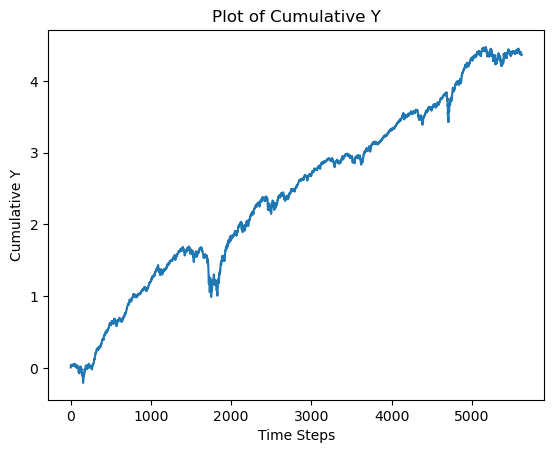

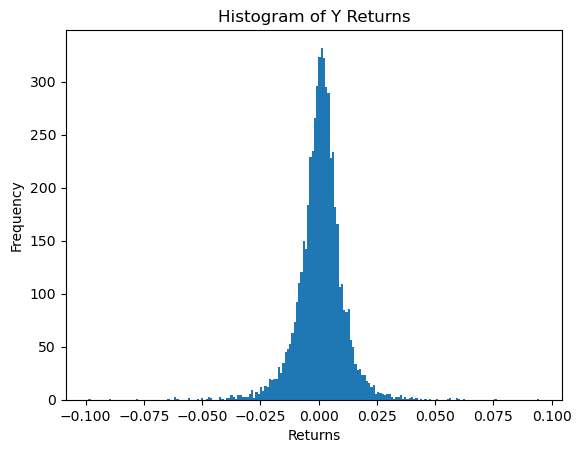

In [9]:
returns = pd.read_csv('Index_Replication_Data/X_USD.csv', index_col=0, header=0, parse_dates=True, keep_default_na=True, na_values=['NA'], delimiter=';', decimal=",")
returns.dropna(axis=1, inplace=True)
returns = returns[returns.index.dayofweek < 5]
returns.shape
#X = returns.iloc[:, :-900]
X = returns[returns.columns[-100:]]

index, rweights = generate_index(returns[returns.columns[-100:]])
Y = index
cumulative_y = np.cumsum(Y)

plt.plot(cumulative_y)
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Y')
plt.title('Plot of Cumulative Y')
plt.show()

plt.hist(Y, bins=200)
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.title('Histogram of Y Returns')
plt.show()

X = X.values

### Cross validation of the hidden layer dimension(compression level)

In [24]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)
Nb_least_comm = 25
Nb_most_comm = 10
hidden_dim = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25]
tracking_errors = []
t_costs = []
prev_weights = 0
validation_itr = TimeSeriesSplit(n_splits=len(hidden_dim)).split(X_train, Y_train)

for j, (train_idx, test_idx) in enumerate(validation_itr):

    print(f"Fold {j}:")
    print(f"  Train: index={train_idx}")
    print(f"  Test:  index={test_idx}")

    #X_train_h, Y_train_h = X[(split_index_here - 5 * 28):split_index_here], Y[(split_index_here - 5 * 28):split_index_here]

    Res = sparse_autoencoder(X_train[train_idx], X_train[test_idx], Nb_most_comm, Nb_least_comm, hidden_dim[j])
    selected_X_test, selected_X_train, _, _, Nb_least_comm_val = Res

    results = ols_regression(selected_X_train, Y_train[train_idx])
    predicted_values = results.predict(sm.add_constant(selected_X_test))
    tracking_error = np.sqrt(compute_mse(predicted_values, Y_train[test_idx]))
    tracking_errors.append(tracking_error)
    t_costs.append(implied_t_costs(results.params, prev_weights, ABS_TCOSTS, REL_TCOSTS))

best_dim = hidden_dim[np.argmin(tracking_errors)]
total_implied_t_costs = np.sum(t_costs)
print("Implied Transaction Costs:", total_implied_t_costs)
print("Best hidden_dim:", best_dim)

Fold 0:
  Train: index=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240

### Use cross validated dim on whole dataset and see how it tracks just taking initial position and wait 


Epoch 1/40
36/36 [==============================] - 1s 6ms/step - loss: 0.2130 - val_loss: 0.2128
Epoch 2/40
36/36 [==============================] - 0s 4ms/step - loss: 0.1236 - val_loss: 0.1017
Epoch 3/40
36/36 [==============================] - 0s 4ms/step - loss: 0.0382 - val_loss: 0.0151
Epoch 4/40
36/36 [==============================] - 0s 4ms/step - loss: 0.0086 - val_loss: 0.0029
Epoch 5/40
36/36 [==============================] - 0s 4ms/step - loss: 0.0034 - val_loss: 0.0013
Epoch 6/40
36/36 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 8.6078e-04
Epoch 7/40
36/36 [==============================] - 0s 4ms/step - loss: 0.0016 - val_loss: 6.9617e-04
Epoch 8/40
36/36 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 6.2126e-04
Epoch 9/40
36/36 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 5.8226e-04
Epoch 10/40
36/36 [==============================] - 0s 4ms/step - loss: 9.5255e-04 - val_loss: 5.5942

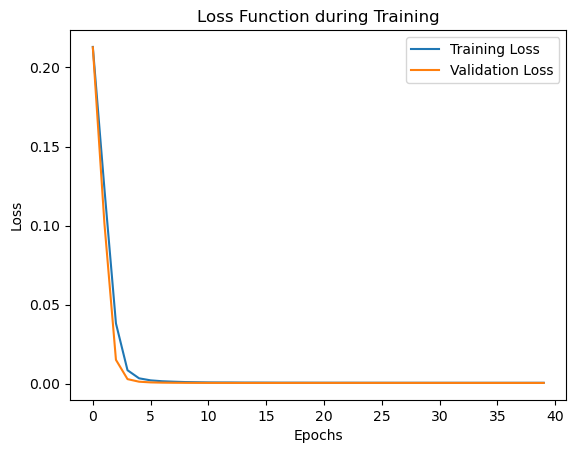

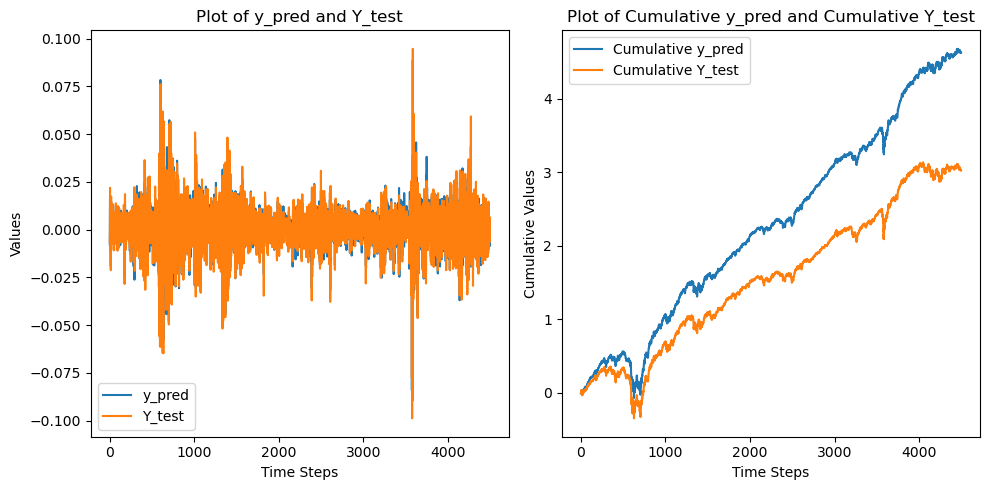

Tracking Error: 0.003160200739613772


In [31]:
#Use cross validated dim on whole dataset 

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.8, shuffle=False)

Res = sparse_autoencoder(X_train, X_test, Nb_most_comm, Nb_least_comm, best_dim)
selected_X_test, selected_X_train, _, _, Nb_least_comm_val = Res
results = ols_regression(selected_X_train, Y_train)
coeff = results.params
print(coeff.shape)

# Do regression using fitted coefficient to predict y on test set
print("The transaction costs are,",implied_t_costs(coeff, 0, ABS_TCOSTS, REL_TCOSTS))
predicted_values = results.predict(sm.add_constant(selected_X_test))
# Compute the cumulative values
cumulative_predicted_values = np.cumsum(predicted_values)
cumulative_Y_test = np.cumsum(Y_test)
tracking_error = np.sqrt(compute_mse(predicted_values, Y_test))

# PLOTTING RESULTS

history = Res[4]
# Plot the loss function
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Function during Training')
plt.legend()
plt.show()

# Plot the predicted values and Y_test
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(predicted_values, label='y_pred')
plt.plot(Y_test, label='Y_test')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.title('Plot of y_pred and Y_test')
plt.legend()

# Compute the cumulative values
cumulative_predicted_values = np.cumsum(predicted_values)
cumulative_Y_test = np.cumsum(Y_test)

plt.subplot(1, 2, 2)
plt.plot(cumulative_predicted_values, label='Cumulative y_pred')
plt.plot(cumulative_Y_test, label='Cumulative Y_test')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Values')
plt.title('Plot of Cumulative y_pred and Cumulative Y_test')
plt.legend()

plt.tight_layout()
plt.show()

print("Tracking Error:", tracking_error)

### Random selection process, for comparison  



c:\Users\alexj\financial-machine-learning-projects-group2\.conda\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\alexj\financial-machine-learning-projects-group2\.conda\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\alexj\financial-machine-learning-projects-group2\.conda\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\alexj\financial-machine-learning-projects-group2\.conda\lib\site-packages\seaborn\_oldcore.py

Mean Average Tracking Error for random selection sample: 0.003348898104339044


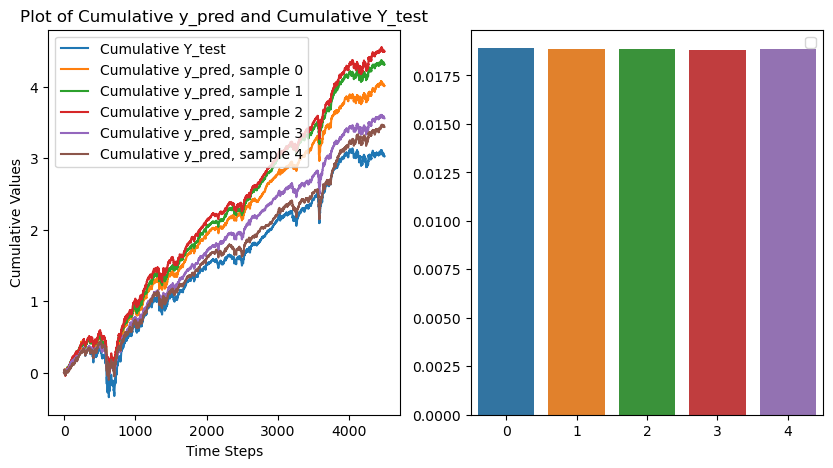

In [32]:
import random

def random_feature_selection(X, num_features):
    # Get the number of columns in X
    num_columns = X.shape[1]

    # Select num_features random column indices
    selected_indices = random.sample(range(num_columns), num_features)

    # Return the selected columns of X
    return X[:, selected_indices]

num_iterations = 5  # Number of iterations to repeat the code block
tracking_errors = []  # List to store tracking errors
t_costs = []  # List to store transaction costs

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

cumulative_Y_test = np.cumsum(Y_test)
sns.lineplot(cumulative_Y_test, label='Cumulative Y_test', ax=axs[0])

for i in range(num_iterations):
    # Perform the same task as the previous cell
    selected_X_train_random = random_feature_selection(X_train, selected_X_train.shape[1])
    results = ols_regression(selected_X_train_random, Y_train)

    # Get the predicted values
    selected_X_test_random = random_feature_selection(X_test, selected_X_train.shape[1])
    predicted_values_random = results.predict(sm.add_constant(selected_X_test_random))
    
    cumulative_predicted_values = np.cumsum(predicted_values_random)

    sns.lineplot(cumulative_predicted_values, label='Cumulative y_pred, sample ' + str(i), ax=axs[0])
    t_costs.append(implied_t_costs(results.params, 0, ABS_TCOSTS, REL_TCOSTS))

    tracking_error_random = compute_mse(predicted_values_random, Y_test)
    tracking_errors.append(tracking_error_random)

axs[0].set_xlabel('Time Steps')
axs[0].set_ylabel('Cumulative Values')
axs[0].set_title('Plot of Cumulative y_pred and Cumulative Y_test')

sns.barplot(x=list(range(num_iterations)), y=t_costs, ax=axs[1])
plt.legend()

mean_tracking_error = sum(tracking_errors) / len(tracking_errors)
print("Mean Average Tracking Error for random selection sample:", np.sqrt(mean_tracking_error))


## With rebalancing same rolling window approach as lasso for test/training

300
Epoch 1/40
10/10 [==============================] - 1s 18ms/step - loss: 0.2452 - val_loss: 0.2437
Epoch 2/40
10/10 [==============================] - 0s 9ms/step - loss: 0.2252 - val_loss: 0.2371
Epoch 3/40
10/10 [==============================] - 0s 9ms/step - loss: 0.2041 - val_loss: 0.2269
Epoch 4/40
10/10 [==============================] - 0s 9ms/step - loss: 0.1807 - val_loss: 0.2119
Epoch 5/40
10/10 [==============================] - 0s 9ms/step - loss: 0.1541 - val_loss: 0.1908
Epoch 6/40
10/10 [==============================] - 0s 9ms/step - loss: 0.1254 - val_loss: 0.1629
Epoch 7/40
10/10 [==============================] - 0s 9ms/step - loss: 0.0973 - val_loss: 0.1292
Epoch 8/40
10/10 [==============================] - 0s 9ms/step - loss: 0.0710 - val_loss: 0.0939
Epoch 9/40
10/10 [==============================] - 0s 9ms/step - loss: 0.0490 - val_loss: 0.0623
Epoch 10/40
10/10 [==============================] - 0s 9ms/step - loss: 0.0327 - val_loss: 0.0383
Epoch 11/40
10

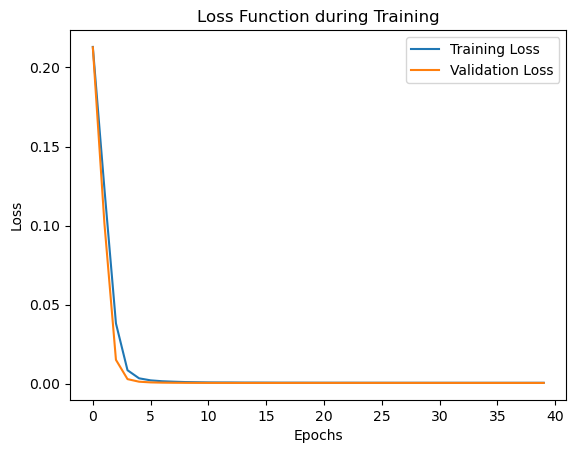

360
Epoch 1/40
10/10 [==============================] - 1s 18ms/step - loss: 0.2533 - val_loss: 0.2441
Epoch 2/40
10/10 [==============================] - 0s 9ms/step - loss: 0.2333 - val_loss: 0.2387
Epoch 3/40
10/10 [==============================] - 0s 9ms/step - loss: 0.2134 - val_loss: 0.2298
Epoch 4/40
10/10 [==============================] - 0s 9ms/step - loss: 0.1914 - val_loss: 0.2162
Epoch 5/40
10/10 [==============================] - 0s 9ms/step - loss: 0.1662 - val_loss: 0.1968
Epoch 6/40
10/10 [==============================] - 0s 9ms/step - loss: 0.1389 - val_loss: 0.1710
Epoch 7/40
10/10 [==============================] - 0s 8ms/step - loss: 0.1102 - val_loss: 0.1392
Epoch 8/40
10/10 [==============================] - 0s 8ms/step - loss: 0.0826 - val_loss: 0.1044
Epoch 9/40
10/10 [==============================] - 0s 8ms/step - loss: 0.0593 - val_loss: 0.0715
Epoch 10/40
10/10 [==============================] - 0s 8ms/step - loss: 0.0401 - val_loss: 0.0452
Epoch 11/40
10

In [46]:
import re


Y_pred_final_LS = []

rebalance = 60
split_index = rebalance*5

Nb_most_comm = 5
Nb_least_com = 15

prev_weights = 0
t_costs = []

relative_drawdowns = []

#Nb_least_com = int(np.linspace(10, 50, 20))

#for j in Nb_least_com:
#try iterate over number of least comm features and see how trracking error goes, if seems interesting 
#might want to inlude crosse validation in the process and then adjust it dynamically$


for i in range(0, X.shape[0]-split_index, rebalance):
    # split_index_here = int(0.8 * len(X.T) + i)  # Use 80% of the data for training
    split_index_here = 5*rebalance + i
    print(split_index_here)
    X_train, Y_train = X[(split_index_here - 5 * rebalance):split_index_here], Y[(split_index_here - 5 * rebalance):split_index_here]

    # For testing, take only 28 after split_index_here
    X_test, Y_test = X[split_index_here:(split_index_here + rebalance)], Y[split_index_here:(split_index_here + rebalance)]

    Res = sparse_autoencoder(X_train, X_test, Nb_most_comm, Nb_least_com, best_dim)

    if i == 0:
        # Plot the loss function
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Loss Function during Training')
        plt.legend()
        plt.show()
    
    selected_X_test, selected_X_train, _,_, Nb_least_comm_val = Res

    results = ols_regression(selected_X_train,Y_train)
    coeff = results.params
    t_costs.append(implied_t_costs(coeff, prev_weights, ABS_TCOSTS, REL_TCOSTS))

    prev_weights = coeff

    #do regression using fitted coefficient to predict y on test set 
    predicted_values = results.predict(sm.add_constant(selected_X_test))
    Y_pred_final_LS.extend(predicted_values)
    relative_drawdowns.append(compute_rel_drawdown(np.cumsum(predicted_values)))

print("Avg. Implied Transaction Costs per rebalancing period:", np.average(t_costs))
print("Avg. Relative Drawdown per rebalancing period:", np.average(relative_drawdowns))


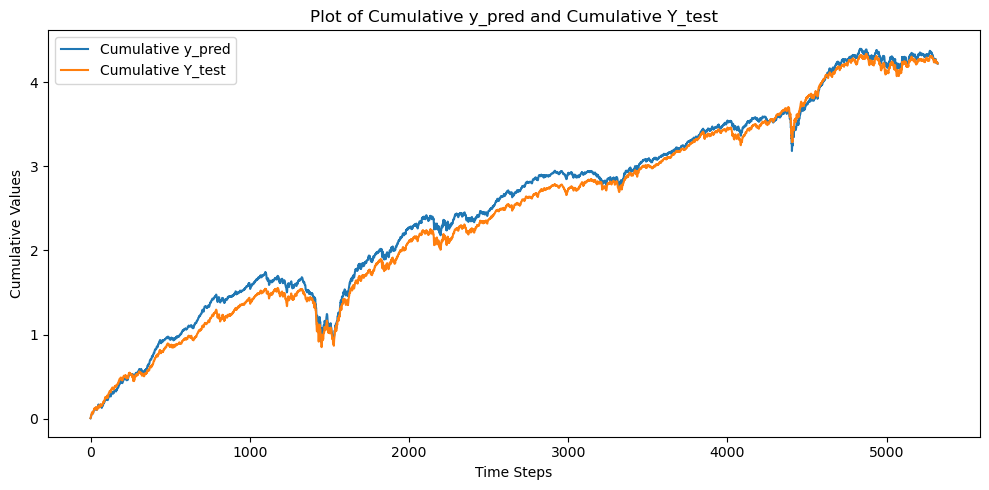

Number of selected features: 20
Tracking Error: 0.1141970805285879


In [48]:
Y_pred_final_LS
# Compute the cumulative values
cumulative_predicted_values = np.cumsum(Y_pred_final_LS)
cumulative_Y_test = np.cumsum(Y_test)
cum_returns_real = np.cumsum(Y[split_index:])

plt.figure(figsize=(10, 5))

plt.plot(cumulative_predicted_values, label='Cumulative y_pred')
plt.plot(cum_returns_real, label='Cumulative Y_test')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Values')
plt.title('Plot of Cumulative y_pred and Cumulative Y_test')
plt.legend()

plt.tight_layout()
plt.show()

print("Number of selected features:", selected_X_test.shape[1])

tracking_error = np.sqrt(compute_mse(cum_returns_real, cumulative_predicted_values))
print("Tracking Error:", tracking_error)

In [15]:
#set a mean squaresd error treshold and then see how many features are selected
#then do cross validation on the number of features selected
#get treshhold from lasso regression results on same length of data with the crossvalidated alpha 

#in parctice, setup your alpha so that implied t costs and T-cost/tracking error is okay for you in lasso approach, then tune treshhold accordingy here and 
#is autoencoder is better than lasso regression, then you should be able to get same tracking performance with less features.

Treshhold = 0.0001







